<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/415_reglin_4.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(group-comp-notebook)=
# Confronto tra le medie di due gruppi

Nel capitolo {ref}`two_groups_comparison_notebook`, abbiamo esaminato come effettuare l'inferenza sulla differenza tra le medie di due campioni indipendenti usando un modello bayesiano. In questo approccio, trattiamo i due gruppi come entità separate e calcoliamo direttamente la differenza tra le loro medie. Per fare ciò, utilizziamo distribuzioni a priori per i parametri del modello, come le deviazioni standard e le medie, e poi aggiorniamo queste distribuzioni a posteriori utilizzando i dati osservati.

Tuttavia, possiamo ottenere lo stesso risultato utilizzando un modello di regressione. Invece di calcolare direttamente la differenza tra le medie dei due gruppi, includiamo una variabile "dummy" nel modello di regressione. Questa variabile "dummy" ci permette di rappresentare in modo binario l'appartenenza dei dati ai gruppi: assegniamo il valore 0 a un gruppo di riferimento e il valore 1 al gruppo di confronto. Successivamente, il modello di regressione stima un parametro di regressione associato alla variabile "dummy", che rappresenta proprio la differenza tra le medie dei due gruppi. Quindi, la variabile "dummy" funge da indicatore per il gruppo e ci consente di ottenere la stima della differenza tra le medie dei due gruppi in modo efficiente.

Entrambi gli approcci sono validi per l'inferenza sulla differenza tra le medie dei due gruppi indipendenti, ma il modello di regressione offre una maggiore flessibilità e possibilità di espansione. Infatti, possiamo includere ulteriori variabili esplicative nel modello di regressione per comprendere meglio i fattori che influenzano il risultato di interesse. Questa flessibilità è particolarmente utile quando vogliamo esplorare come altre variabili possano contribuire alla differenza tra le medie dei gruppi o quando desideriamo considerare più fattori simultaneamente.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

## Modello di regressione per due gruppi indipendenti

In termini bayesiani, possiamo formulare il modello di regressione nel modo seguente:

$$
\begin{align}
y_i   & \sim \mathcal{N}(\mu_i, \sigma)\\\notag
\mu_i & = \alpha + \beta x_i
\end{align}
$$

dove

- $\alpha$ rappresenta l'intercetta,
- $\beta$ rappresenta la pendenza,
- $\sigma$ rappresenta l'errore di osservazione.

Per il gruppo codificato con $x = 0$, il modello diventa

$$
\begin{align}
y_i   & \sim \mathcal{N}(\mu_i, \sigma)\\\notag
\mu_i & = \alpha
\end{align}
$$

Ciò significa che il parametro $\alpha$ corrisponde alla media del gruppo condificato con $x = 0$.

Per il gruppo codificato con $x = 1$, il modello diventa

$$
\begin{align}
y_i   & \sim \mathcal{N}(\mu_i, \sigma)\\\notag
\mu_i & = \alpha + \beta
\end{align}
$$

In questo contesto, la media del gruppo codificato con $x = 1$ è rappresentata da $\alpha$ sommata a $\beta$, che rappresenta la differenza tra la media del gruppo codificato con $x = 1$ e la media del gruppo codificato con $X = 0$. Di conseguenza, l'inferenza sulla differenza tra le medie dei due gruppi può essere effettuata tramite l'inferenza sul parametro $\beta$. In altre parole, il confronto tra le medie dei due gruppi può essere svolto esaminando la distribuzione a posteriori del parametro $\beta$.

## Un esempio illustrativo

Esaminiamo nuovamente i dati relativi al quoziente di intelligenza dei bambini le cui madri hanno completato oppure no la scuola superiore. Ci poniamo il problema di replicare i risultati ottenuti in precedenza usando l'analisi di regressione.

Leggiamo i dati:

In [3]:
kidiq = pd.read_stata("../data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
kidiq.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

Ci sono 93 bambini la cui madre non ha completato le superiori e 341 bambini la cui madre ha ottenuto il diploma di scuola superiore.

In [5]:
summary_stats = [st.mean, st.stdev]
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

Iniziamo l'inferenza statistica sulla differenza tra le medie dei due gruppi utilizzando `bambi`. Questo pacchetto offre una sintassi semplice per formulare il modello bayesiano di interesse. Un altro vantaggio è che `bambi` selezionerà automaticamente le distribuzioni a priori appropriate per i parametri del modello, rendendo il processo più intuitivo.

Il modello di regressione sopra descritto si scrive nel modo seguente.

In [6]:
mod = bmb.Model("kid_score ~ mom_hs", kidiq)

Effettuiamo il campionamento.

In [7]:
results = mod.fit(draws=5000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, mom_hs]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


Esaminiamo le distribuzioni a posteriori dei parametri del modello.

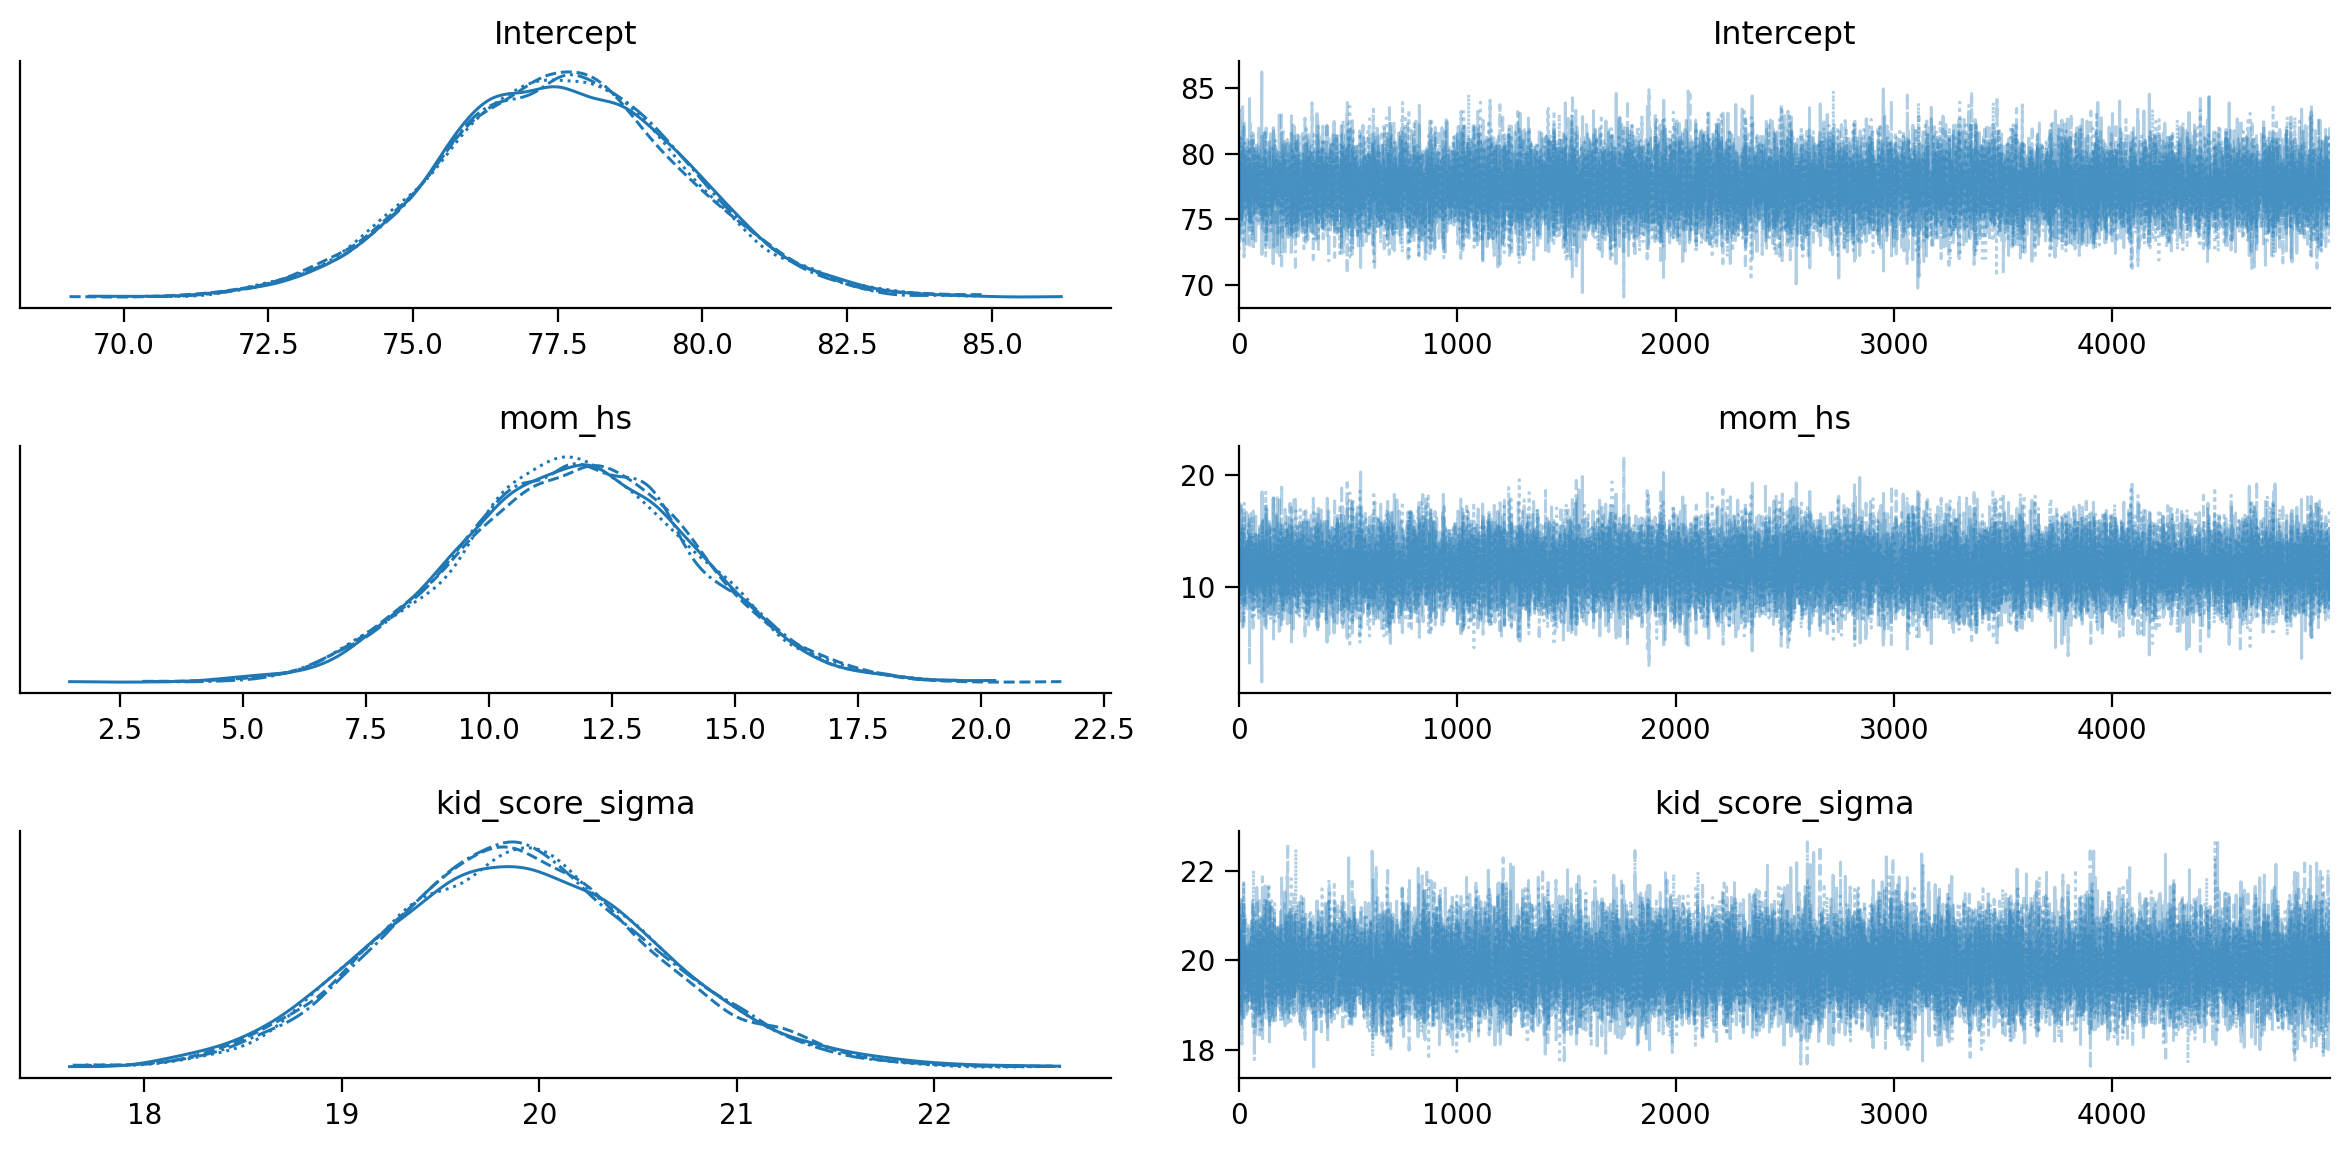

In [9]:
az.plot_trace(results);

In [10]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,77.546,2.081,73.591,81.450,0.012,0.008,31164.0,15987.0,1.0
mom_hs,11.768,2.352,7.280,16.097,0.013,0.010,30771.0,15487.0,1.0
kid_score_sigma,19.893,0.685,18.589,21.171,0.004,0.003,30648.0,15043.0,1.0


Il parametro "Intercept" rappresenta la stima a posteriori del punteggio del QI per il gruppo codificato con "mom_hs" uguale a 0. La media a posteriori di questo gruppo è di 77.6, che è praticamente identica al valore campionario corrispondente.

Il parametro "mom_hs" corrisponde alla stima a posteriori della differenza nei punteggi del QI tra il gruppo codificato con "mom_hs" uguale a 1 e il gruppo codificato con "mom_hs" uguale a 0. Anche in questo caso, la differenza a posteriori di 11.8 tra le medie dei due gruppi è molto simile alla differenza campionaria tra le medie dei due gruppi. La parte importante della tabella riguarda l'intervallo di credibilità al 94%, che è [7.5, 16.2], e che non include lo 0. Ciò significa che, con un livello di certezza soggettiva del 94%, possiamo essere sicuri che il QI dei bambini le cui madri hanno il diploma superiore sarà maggiore (in media) di almeno 7.5 punti, e tale differenza può arrivare fino a 16.2 punti, rispetto al QI dei bambini le cui madri non hanno completato la scuola superiore.

Se confrontiamo questi risultati con quelli ottenuti nel capitolo {ref}`two_groups_comparison_notebook`, notiamo che sono quasi identici. Le piccole differenze che si osservano possono essere attribuite sia all'approssimazione numerica sia al fatto che nel modello precedente abbiamo consentito deviazioni standard diverse per i due gruppi, mentre nel caso attuale abbiamo assumo la stessa variabilità per entrambi i gruppi.

Per completezza, ripetiamo l'analsi precedente specifando il modello bayesiano con PyMC.

In [11]:
μ_m = kidiq.kid_score.mean()
μ_s = kidiq.kid_score.std() * 3

with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=30)
    # Expected value of outcome
    mu = alpha + beta * kidiq["mom_hs"] 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kidiq["kid_score"])

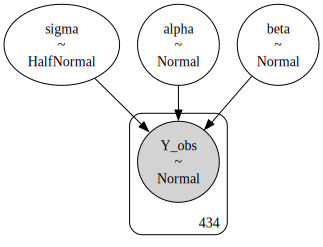

In [12]:
pm.model_to_graphviz(model)

Esaminiamo la distribuzione predittia a priori.

In [13]:
with model:
    prior_samples = pm.sample_prior_predictive(1000)

Sampling: [Y_obs, alpha, beta, sigma]


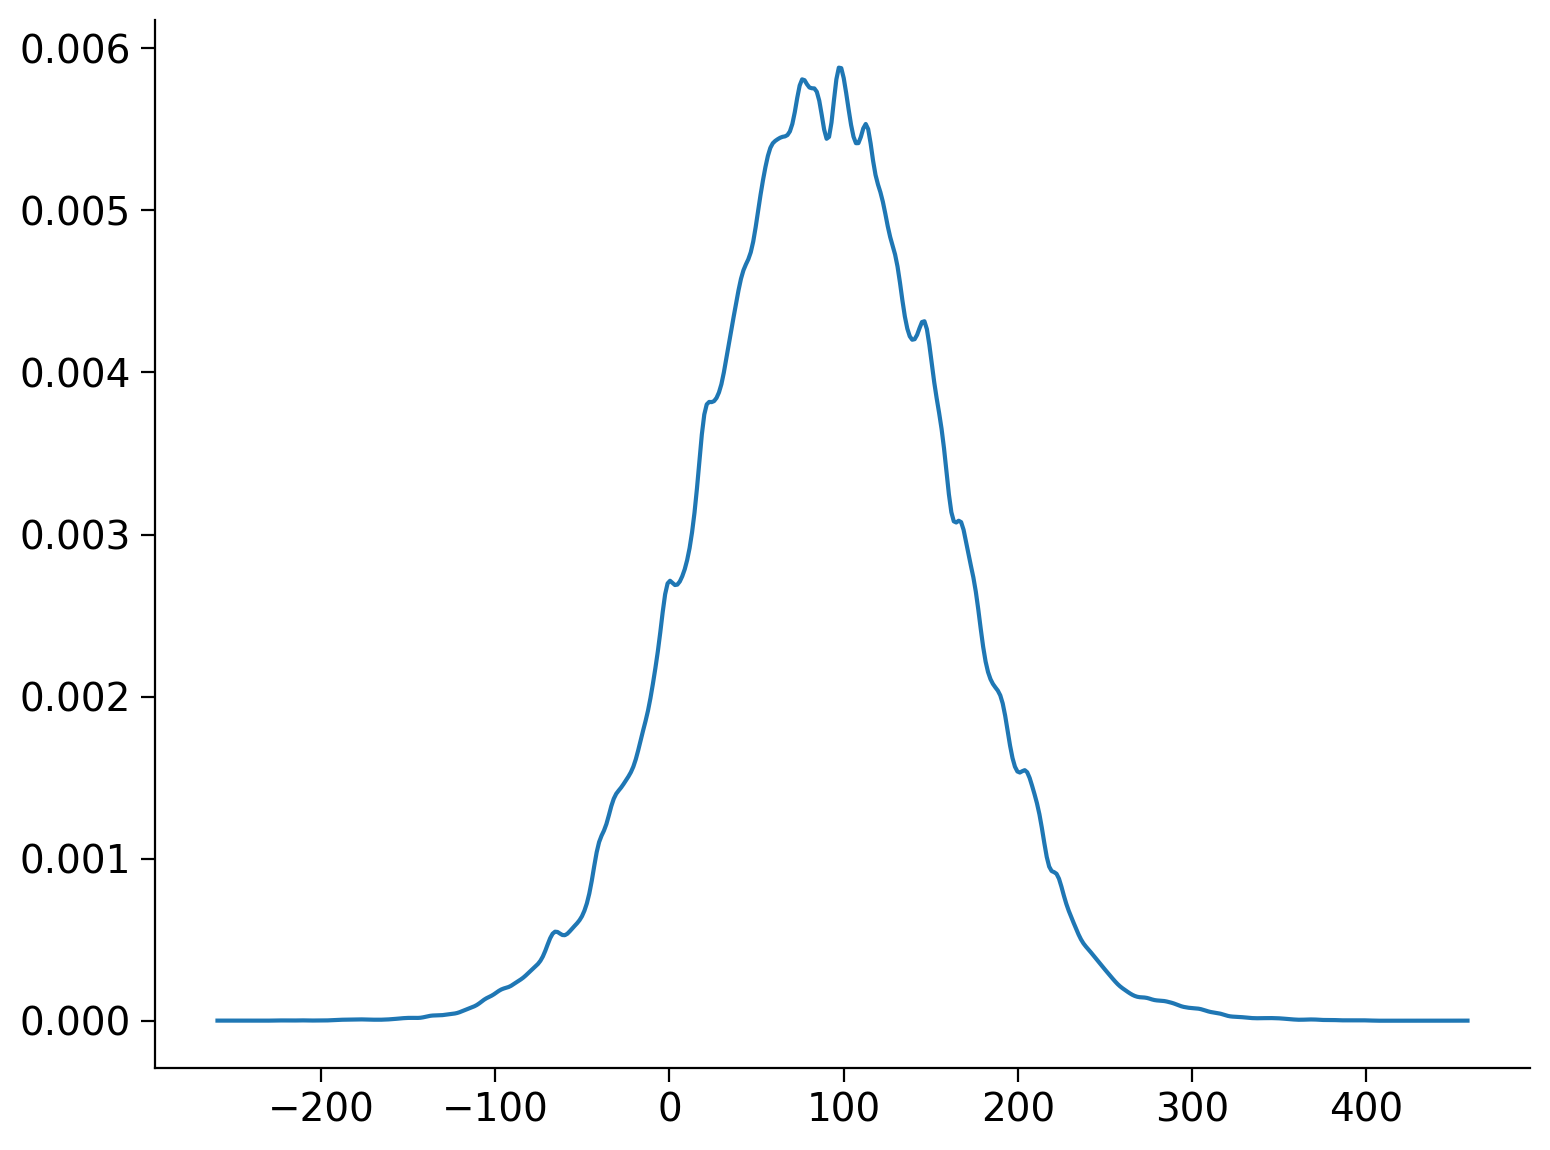

In [14]:
az.plot_dist(prior_samples.prior_predictive["Y_obs"]);

Eseguiamo il campionamento.

In [15]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Esaminiamo i risultati.

In [16]:
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,78.03,1.98,74.25,81.65
beta,11.15,2.22,6.78,15.07
sigma,19.91,0.69,18.68,21.19


I risultati replicano quelli ottenuti in precedenza.

Aggiungiamo al modello bayesiano la stima della grandezza dell'effetto.

In [17]:
with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=30)
    # Expected value of outcome
    mu = alpha + beta * kidiq["mom_hs"] 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kidiq["kid_score"])
    
    effect_size = pm.Deterministic("effect size", beta / sigma)
    
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


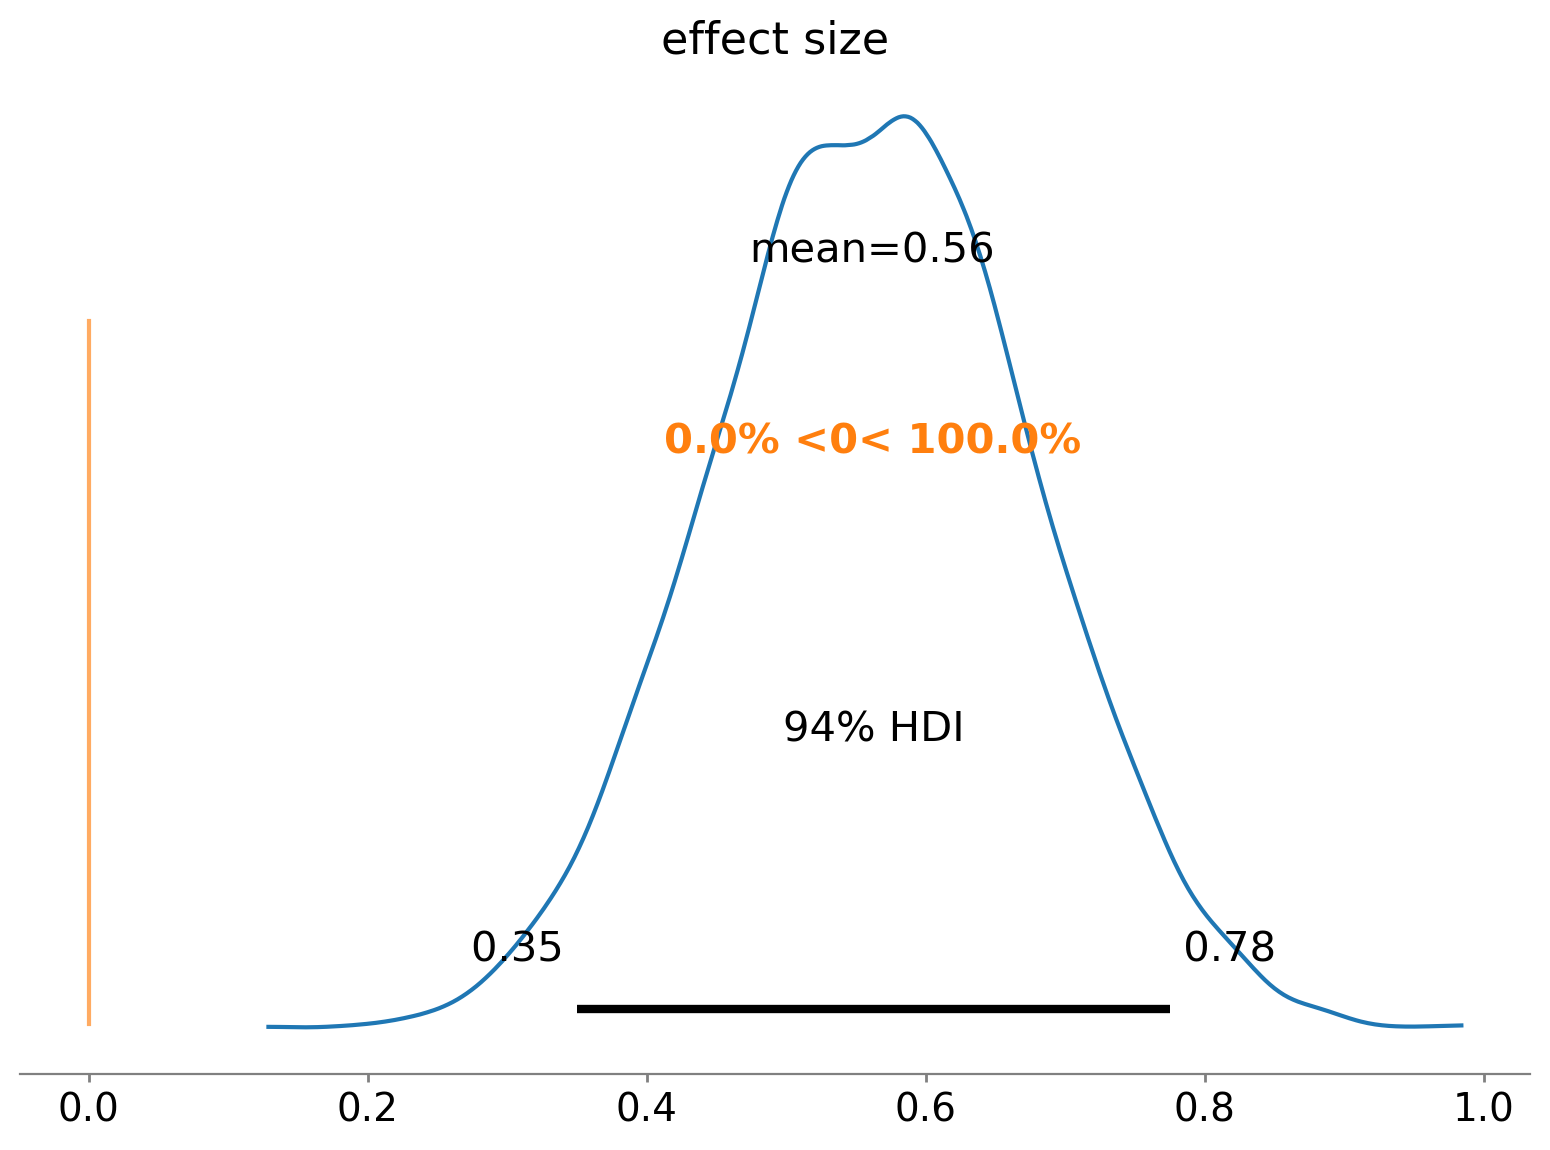

In [18]:
az.plot_posterior(trace, ref_val=0, var_names=["effect size"]);

In [19]:
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,78.02,1.99,74.42,81.87
beta,11.16,2.23,7.18,15.52
sigma,19.89,0.67,18.66,21.15
effect size,0.56,0.11,0.35,0.78


Anche in questo caso i risultati replicano quelli ottenuti in precedenza.

## Watermark

In [20]:
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Aug 16 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

bambi     : 0.12.0
pymc      : 5.7.2
matplotlib: 3.7.2
numpy     : 1.25.2
pandas    : 2.0.3
scipy     : 1.11.1
arviz     : 0.16.1

Watermark: 2.4.3

